Work in progress. Matrix in question is
$$ A =\begin{bmatrix}1.5 &  0.5 \\  0.5 & 1.5 \end{bmatrix} $$
and 
$$ \vert b \rangle = \frac{1}{\sqrt{2}}\big( \vert 0 \rangle + \vert 1 \rangle \big) $$


In [186]:
import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from collections import namedtuple
from qiskit import QuantumProgram
from qiskit.tools.visualization import *
# import Qconfig

qasm = 'local_qasm_simulator'
usim = 'local_unitary_simulator'
qx2 = 'ibmqx2'
qx4 = 'ibmqx4'
qx5 = 'ibmqx5'
qxsim = 'ibmqx_qasm_simulator'

PhaseEstimate = namedtuple('trial','cname m result outcome')
Angles = namedtuple('angles','theta phi rho')

phase_f = lambda k,l: -l*np.pi/2**k if l > 0 else -np.pi/2**(k-1)


In [187]:
Q = QuantumProgram()
# Q.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
# conf = Q.get_backend_configuration(backend=qx4)
# cmap = conf["coupling_map"]

In [199]:
def cu_phase(q,c,t,a):
    q.u3(-a.theta,-a.phi,-a.rho,t)
    q.cx(c,t)
    q.u3(a.theta,a.phi,a.rho,t)
    q.cx(c,t)
    
def proc(outcome,cn, res,first=False, last=False):
    count = res.get_counts(cn)
#     if first and max(count,key=count.get) == 0:
#         return outcome 
    outcome[1]+="".join(str(max(count,key=count.get)))
    outcome[0] = int(outcome[1][::-1],2)
    if last:
        outcome[1]= outcome[1][::-1]
        print("last")
    print(outcome[0],outcome[1])
    return outcome 

def get_phase(outcome,m):
    phase = [0]*2
    eig = outcome[0] /2**(m-1)
#     phi = outcome[0] / 2**(m-1)
    phase[0] = np.exp(1j*2*np.pi*eig)
    phase[1] = np.exp(-1j*2*np.pi*eig)
    print("Phase: ", phase)
    print("Eigenvalue: ", eig)
    return eig


def get_phase(outcome,m,registers=1):
    if registers > 1:
        int(outcome[0][::-1],2)
    phase = [0]*2
    eig = outcome[0] /2**(m-1)
#     phi = outcome[0] / 2**(m-1)
    phase[0] = np.exp(1j*2*np.pi*eig)
    phase[1] = np.exp(-1j*2*np.pi*eig)
    print("Phase: ", phase)
    print("Eigenvalue: ", eig)
    return eig



In [200]:
def phase_estimate(c_name, q, c, m, n, outcome,params):
    phase = Q.create_circuit(c_name, [q], [c])
    phase.h(q[0])
    phase.h(q[1])
    for k in range(2**(m-1-n)):
        cu_phase(phase,q[0],q[1],params)
    if n > 0: 
        phase.u1(phase_f(n,outcome[0]), q[0])
    phase.h(q[0])
    
    phase.measure(q[0],c[0])
    
    r = Q.execute(c_name,
                  backend=qasm, 
                  shots=1024, 
                  wait=10,
                  timeout=440)
    outcome = proc(outcome, c_name, r,first=True if n==0 else False, last=True if m-n==1 else False)
    return PhaseEstimate(cname=c_name, m=m, result=r, outcome=outcome)

In [249]:
theta = np.pi/2
phi = 0
rho = 0
params = Angles(theta,phi,rho)
m = 2
n = 0

gates = lambda q,t: [ q.u3(-theta, -phi, -rho, t), q.u3(theta, phi, rho, t) ]

q = Q.create_quantum_register("q", 2)
c = Q.create_classical_register("c", 1)
cname = ['phase4','phase3','phase2','phase1']

runs = []
for k in range(m):
    if k == 0:
        runs.append(phase_estimate(("phase%d" %(m-k)), q, c,m,n, [0,""], params))
    else:
        runs.append(phase_estimate(("phase%d" %(m-k)), q, c,m,n+k, runs[-1].outcome,params))

1 1
last
3 11


In [245]:
res = runs[-1].result.get_counts(cname[-1])
outcomes = []
for k in res.keys():
    outcomes.append([res[k],k])
outcomes[0] = proc(outcomes[0],runs[-1].cname,runs[-1].result,last=True)
outcomes[1] = proc(outcomes[1],runs[-1].cname,runs[-1].result,last=True)
outcomes = np.asarray(outcomes); outcomes

last
2 10
last
3 11


array([['2', '10'],
       ['3', '11']], dtype='<U21')

In [252]:
# This is pretty ad hoc. There should be a 1 bit phase difference

eigs = []
l1 = sum(x != y for x,y in zip((outcomes[0,1]),(outcomes[1,1])))
# if l1 == 1:
b1=outcomes[0,1]
b2=outcomes[1,1]
# b2 = format( ((int(b2,2)) - (int(b1,2)))  , '02b'); b2
if b2 == '00':
    b2 = format( ((int(b1,2)) + (int(b1,2)))  , '02b'); b2
if b2 == '11':
     b2 = format( ((int(b2,2)) - (int(b1,2)))  , '02b'); b2

eigs.append(int(b1,2))
eigs.append(int(b2,2))
print("Eigenvalues: ", eigs)

Eigenvalues:  [2, 1]


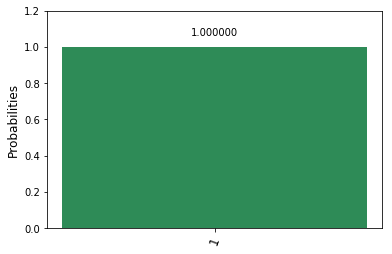

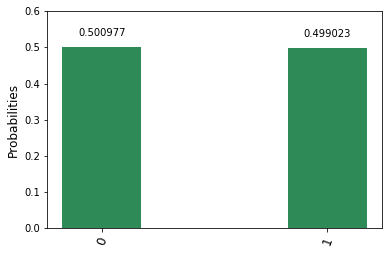

In [233]:
for res in runs:
    plot_histogram(res.result.get_counts(res.cname))

In [257]:
theta =2*np.arcsin(min(eigs)/max(eigs)); theta

1.0471975511965979

In [254]:
# theta2 = np.pi
Q = QuantumProgram()
# Q.set_api(Qconfig.APItoken, Qconfig.config["url"])
q = Q.create_quantum_register("q", 3)
c = Q.create_classical_register("c", 3)

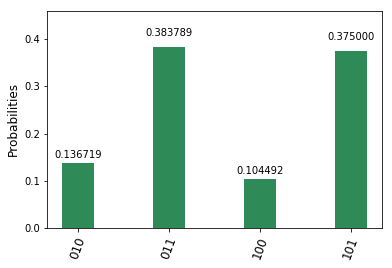

[0.3838 0.1367 0.375  0.1045]
[0.62  0.37  0.612 0.323]


In [256]:
lse = Q.create_circuit("lse", [q], [c])
lse.x(q[0])

lse.h(q[2])
lse.x(q[1])
lse.cx(q[2],q[1])

lse.u3(-np.pi/2,0,0,q[1])
lse.cu3(theta,0,0,q[1],q[0])

lse.u3(np.pi/2,0,0,q[2])
lse.cu3(theta,0,0,q[2],q[0])

lse.measure(q[0],c[0])
lse.measure(q[1],c[1])
lse.measure(q[2],c[2])

            
r = Q.execute("lse",
              backend=qasm, 
              shots=1024, 
              wait=10,
              timeout=300)

plot_histogram(r.get_counts("lse"))
vals = [x/1024 for x in list(r.get_counts("lse").values())]
print(np.round(vals,4))
x = [np.round(np.sqrt(x),3) for x in vals]
print(np.round(x,3))


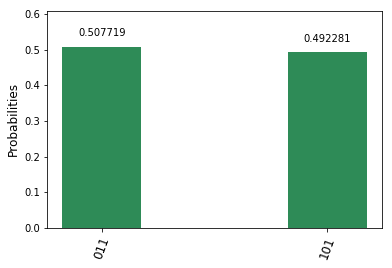

In [25]:
res = r.get_counts('lse'); res
nruns = res['011'] + res['101']; nruns
a = {'011': res['011']/nruns, '101': res['101']/nruns}; a
plot_histogram(a)

In [26]:
bad = res['010'] + res['100']; bad
b = {'010': res['010']/bad, '100': res['100']/bad}; b
bi = [np.sqrt(z) for z in b.values()]

In [27]:
x=[np.sqrt(x)*y for x,y in zip(a.values(),b.values())]
xr = np.array([0.35355339,0.35355339])
err = np.abs(x-xr)
err_p = (err/xr) *100

print('got   x = ({:0<1.5f}, {:1<1.5f})'.format(float(x[0]),float(x[1])))
print('exact x = ({:0<1.5f}, {:1<1.5f})'.format(float(xr[0]),float(xr[1])))
print('error e = ({:0<1.5f}, {:1<1.5f})'.format(float(err[0]),float(err[1])))
print('error % = ({:0<1.5f}, {:1<1.5f})'.format(float(err_p[0]),float(err_p[1])))


got   x = (0.37162, 0.33570)
exact x = (0.35355, 0.35355)
error e = (0.01807, 0.01785)
error % = (5.11043, 5.04988)
